In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
aapl = pd.read_csv('AAPL_CLOSE',index_col='Date',parse_dates=True)
cisco = pd.read_csv('CISCO_CLOSE',index_col='Date',parse_dates=True)
ibm = pd.read_csv('IBM_CLOSE',index_col='Date',parse_dates=True)
amazon = pd.read_csv('AMZN_CLOSE',index_col='Date',parse_dates=True)

In [3]:
stocks = pd.concat([aapl,cisco,ibm,amazon],axis=1)

In [4]:
stocks.columns = ['aapl', 'cisco','ibm','amazon']

In [5]:
stocks.pct_change(1).mean()

aapl      0.000750
cisco     0.000599
ibm       0.000081
amazon    0.001328
dtype: float64

In [6]:
stocks.pct_change(1).corr()

,aapl,cisco,ibm,amazon
aapl,1.000000,0.301990,0.297498,0.235487
cisco,0.301990,1.000000,0.424672,0.284470
ibm,0.297498,0.424672,1.000000,0.258492
amazon,0.235487,0.284470,0.258492,1.000000


In [9]:
log_ret = np.log(stocks/stocks.shift(1))

In [12]:
log_ret.head()

,aapl,cisco,ibm,amazon
Date,,,,
2012-01-03,NaN,NaN,NaN,NaN
2012-01-04,0.005360,0.019139,-0.004088,-0.008526
2012-01-05,0.011041,-0.003693,-0.004754,0.000563
2012-01-06,0.010400,-0.003707,-0.011547,0.027763
2012-01-09,-0.001587,0.006346,-0.005218,-0.022428


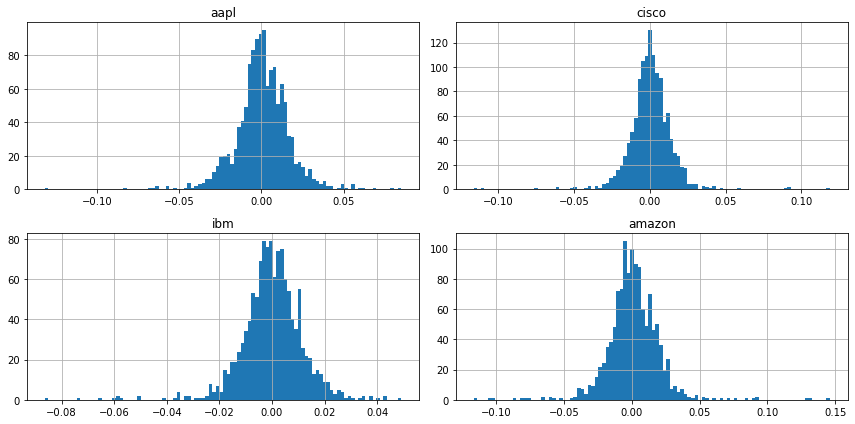

In [14]:
log_ret.hist(bins=100,figsize=(12,6))
plt.tight_layout()

In [15]:
log_ret.mean()

aapl      0.000614
cisco     0.000497
ibm       0.000011
amazon    0.001139
dtype: float64

In [17]:
log_ret.cov()*252

,aapl,cisco,ibm,amazon
aapl,0.068326,0.017854,0.014464,0.018986
cisco,0.017854,0.051381,0.018029,0.019956
ibm,0.014464,0.018029,0.035203,0.014939
amazon,0.018986,0.019956,0.014939,0.094470


In [24]:
np.random.seed(101)
print(stocks.columns)

weights = np.array(np.random.random(4))
print('poids aléatoires:')
print(weights)
print('(re)pondération des poids')
weights = weights /np.sum(weights)
print(weights)

#rendement attendu
print('Rendement attendu du portefeuille')
exp_ret = np.sum(log_ret.mean()*weights*252)
print(exp_ret)

# Volatilité attendue
print ('Volatitlité attendue')
exp_vol = np.sqrt(np.dot(weights.T,np.dot(log_ret.cov()*252,weights)))
print(exp_vol)

# Ratio de sharpe
print('Ratio de Sharpe')
SR = exp_ret/exp_vol
print(SR)

Index(['aapl', 'cisco', 'ibm', 'amazon'], dtype='object')
poids aléatoires:
[0.51639863 0.57066759 0.02847423 0.17152166]
(re)pondération des poids
[0.40122278 0.44338777 0.02212343 0.13326603]
Rendement attendu du portefeuille
0.1559927204963252
Volatitlité attendue
0.1850264956590895
Ratio de Sharpe
0.8430831483926556


In [ ]:
np.sum(log_ret.mean() *weights*252)
print(exp_ret)

